In [1]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.config import config

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force')

last updated: 2018-08-27 
Git hash: b99606c0f732385e29bf233ca406fa3affd1370b


In [98]:
def plot_panel(gs, df, genes):
    fig = plt.gcf()
    gs0 = GridSpecFromSubplotSpec(1, 4, subplot_spec=gs, wspace=0.08)
    ax1 = fig.add_subplot(gs0[0, 0])
    ax2 = fig.add_subplot(gs0[0, 1], sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs0[0, 2], sharex=ax1, sharey=ax1) 
    ax4 = fig.add_subplot(gs0[0, 3], sharex=ax1, sharey=ax1)
    
    axes = [ax1, ax2, ax3, ax4]
    for ax, (g, dd) in zip(axes, df.groupby('Cluster')):
        _genes = genes[g]
        sns.boxplot('XA', 'logTPM', data=dd.query(f'FBgn == {_genes}'), notch=True, showfliers=False, order=['X', 'A', '4'], ax=ax)
        ax.set_title(g, fontsize=10)
        sns.despine(ax=ax)
    
    for ax in axes[1:]:
        ax.set_ylabel('')
        ax.yaxis.set_visible(False)
        sns.despine(ax=ax, left=True)
    
    return axes
        
def plot_boxplot_x2a(gs):
    germ_cells = config['cluster_order'][:4]
    
    chroms = nbconfig.fbgn2chrom.copy()
    chroms.loc[chroms['chrom'] == 'chrX', 'XA'] = 'X'
    chroms.loc[chroms['chrom'] == 'chr4', 'XA'] = '4'
    chroms.loc[chroms['chrom'] == 'chrY', 'XA'] = 'Y'
    chroms.loc[chroms.chrom.isin(['chr2L', 'chr2R', 'chr3L', 'chr3R']), 'XA'] = 'A'
    
    tpm = np.log10(pd.read_parquet('../scrnaseq-wf/data/tpm.parquet', columns=germ_cells) + 1).join(chroms)
    
    melted = tpm.reset_index().melt(id_vars=['FBgn', 'chrom', 'XA'], var_name='Cluster', value_name='logTPM')
    melted.Cluster = pd.Categorical(melted.Cluster, categories=germ_cells, ordered=True)
    
    gs0 = GridSpecFromSubplotSpec(4, 1, subplot_spec=gs, hspace=0.1)
    
    # All genes
    genes = dict(zip(germ_cells, [tpm.index.tolist()]*len(germ_cells)))
    axes = plot_panel(gs0[0, 0], melted, genes)
    for ax in axes:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    ax.text(1.1, 0.5, 'All Genes', ha='left', va='center', rotation=-90, fontsize=10, transform=ax.transAxes)
    
    # Commonly genes
    from larval_gonad.x_to_a import commonly_expressed
    commonly = commonly_expressed(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force')
    genes = dict(zip(germ_cells, [commonly]*len(germ_cells)))
    axes = plot_panel(gs0[1, 0], melted, genes)
    for ax in axes:
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_xticklabels([])
    ax.text(1.1, 0.5, 'Commonly\nExpressed', ha='left', va='center', rotation=-90, fontsize=10, transform=ax.transAxes)

    # Commonly germ genes
    common_germ = tpm.index[(tpm.iloc[:, :-2] > 0).sum(axis=1) > (tpm.shape[1] / 3)].tolist()
    genes = dict(zip(germ_cells, [common_germ]*len(germ_cells)))
    axes = plot_panel(gs0[2, 0], melted, genes)
    for ax in axes:
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_xticklabels([])
    ax.text(1.1, 0.5, 'Germline\nExpressed', ha='left', va='center', rotation=-90, fontsize=10, transform=ax.transAxes)
    
    # upregulated genes
    genes = {
        'Spermatogonia (6)': list(tpm.index),
        'Early 1º Spermatocytes (3)': pd.read_csv('../scrnaseq-wf/data/gonia_vs_early.tsv', sep='\t').query('p_val_adj <= 0.01 & avg_logFC < 0').set_index('primary_FBgn').index.tolist(),
        'Mid 1º Spermatocytes (2)': pd.read_csv('../scrnaseq-wf/data/early_vs_mid.tsv', sep='\t').query('p_val_adj <= 0.01 & avg_logFC < 0').set_index('primary_FBgn').index.tolist(),
        'Late 1º Spermatocytes (0)': pd.read_csv('../scrnaseq-wf/data/mid_vs_late.tsv', sep='\t').query('p_val_adj <= 0.01 & avg_logFC < 0').set_index('primary_FBgn').index.tolist(),
    }
    axes = plot_panel(gs0[3, 0], melted, genes)
    for ax in axes:
        ax.set_title('')
    ax.text(1.1, 0.5, 'Upregulated\nGenes', ha='left', va='center', rotation=-90, fontsize=10, transform=ax.transAxes)

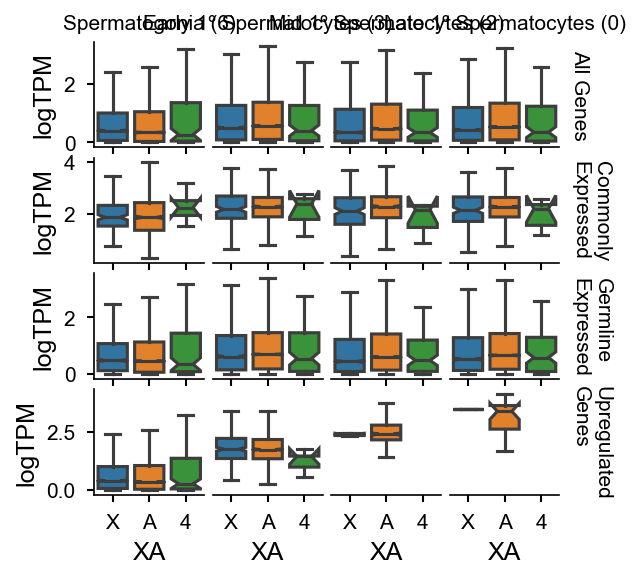

In [100]:
fig = plt.figure(figsize=(4, 4))
gs = GridSpec(1, 1)
plot_boxplot_x2a(gs[0, 0])

In [72]:
import gffutils

db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-16/gtf/dmel_r6-16.gtf.db')

# organize genes by chrom position for easy plotting
locs = []
for gene in db.features_of_type('gene'):
    fbgn = gene.id
    chrom = gene.chrom
    pos = np.min([gene.start, gene.end])
    locs.append((fbgn, chrom, pos))
locs = pd.DataFrame(locs, columns=['FBgn', 'chrom', 'pos']).set_index('FBgn')
locs.chrom = pd.Categorical(locs.chrom, categories=nbconfig.chrom_order, ordered=True)

# remove genes not in the dataset
locs = locs.reindex(tpm.index)

# sort and make an arbitrary location point
locs.sort_values(['chrom', 'pos'], inplace=True)
locs['location'] = range(1, locs['pos'].shape[0] + 1)

In [238]:
fmt = mpl.ticker.FuncFormatter(lambda x, pos: int(np.abs(x)))

In [288]:
def plot(up, down):
    dat = pd.read_csv(f'../scrnaseq-wf/data/{up}_vs_{down}.tsv', sep='\t', index_col=0)
    dat['logpval'] = -np.log10(dat.p_val_adj.replace({0: 1e-300}))

    dat.loc[dat.avg_logFC < 0, 'logpval'] *=-1

    dat = dat.join(locs, how='left')[['chrom', 'location', 'logpval']]
    dat.logpval = dat.logpval.fillna(0)

    fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/4))
    ax.yaxis.set_major_formatter(fmt)
    for g, dd in dat.groupby('chrom'):
        ax.scatter(dd.location, dd.logpval, label=g, s=5)
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    ax.text(-0.05, 0.75, f'{up}', rotation=90, transform=ax.transAxes, ha='right', va='center')
    ax.text(-0.05, 0.25, f'{down}', rotation=90, transform=ax.transAxes, ha='right', va='center')
    
    ax.set_axisbelow(True)
    ax.axhline(0, color='k', alpha=.5, ls=':')
    ax.grid(axis='y', alpha=0.5, ls=':')
    sns.despine(ax=ax, left=True)

In [292]:
np.log10(0.01)

-2.0

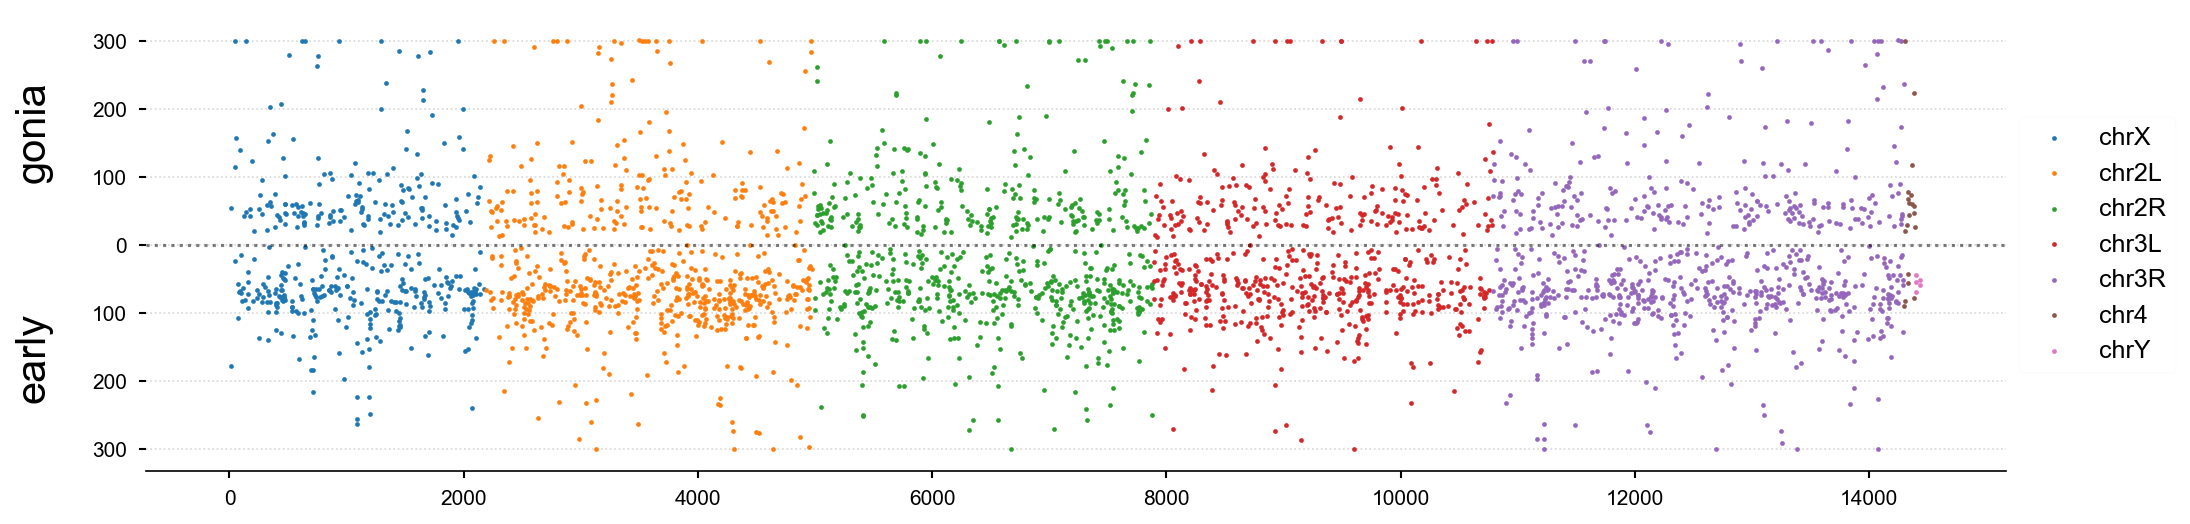

In [289]:
plot('gonia', 'early')

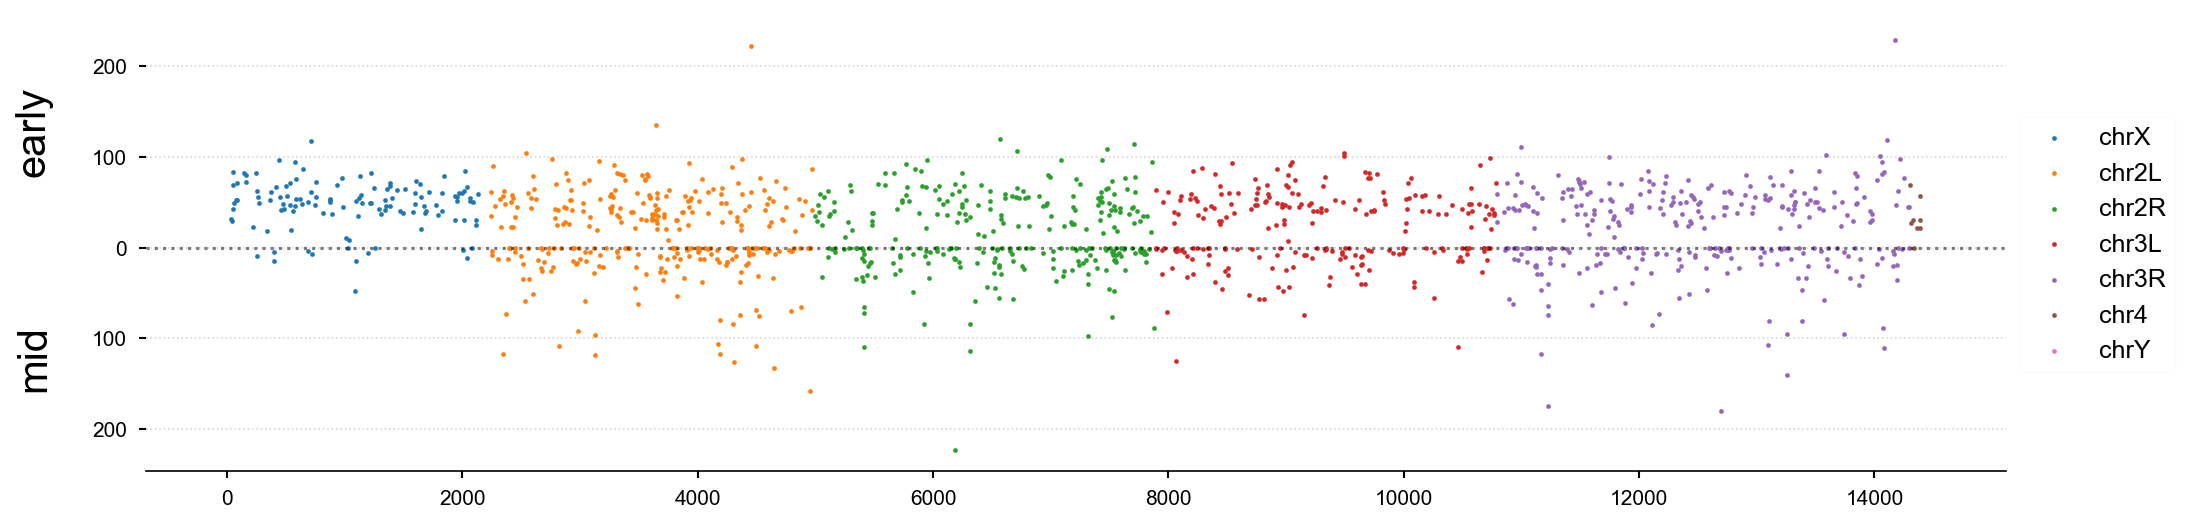

In [290]:
plot('early', 'mid')

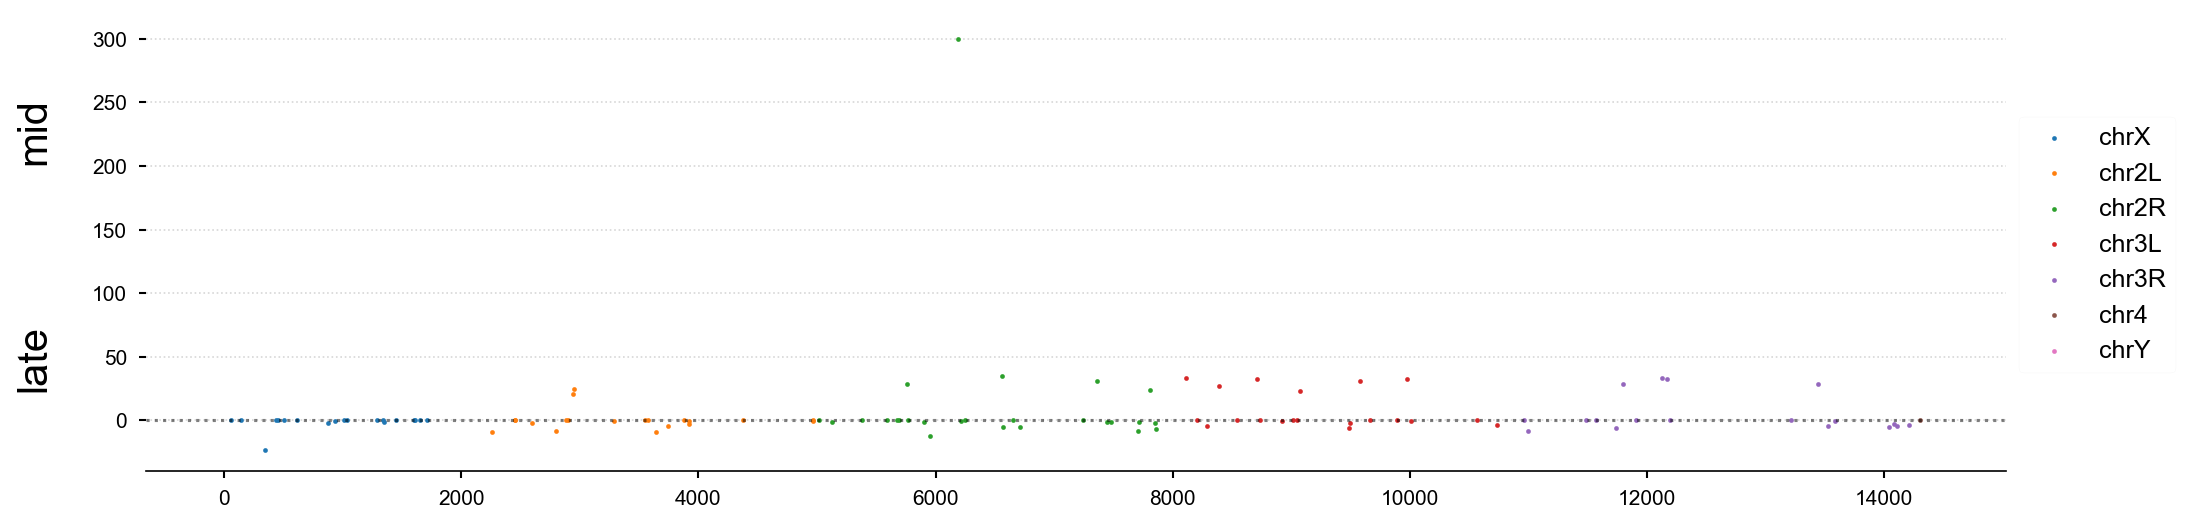

In [291]:
plot('mid', 'late')

In [332]:
import upsetplot

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/upsetplot/plotting.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  totals.append(data.loc[idxslice].sum())


Late 1º Spermatocytes (0)  Mid 1º Spermatocytes (2)  Early 1º Spermatocytes (3)  Spermatogonia (6)
True                       True                      True                        False                77
                                                                                 True                 60
False                      False                     False                       True                 22
                                                     True                        True                 17
                                                                                 False                17
True                       False                     True                        True                 12
                           True                      False                       False                11
                           False                     True                        False                 9
False                      True                      False   

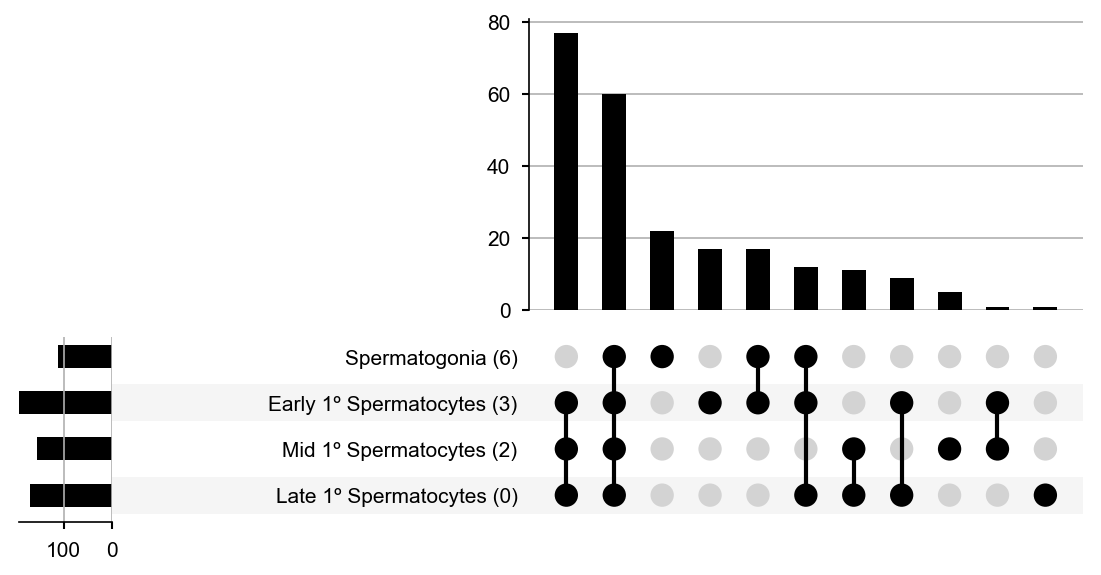

In [589]:
xlink = chroms.query('chrom == "chrX"').index

dat = tpm.iloc[:, :-2] > 2

dat = dat.reindex(xlink).dropna()

dat = dat[dat.sum(axis=1) > 0]

_dat = dat.groupby(germ_cells[::-1]).size().sort_values(ascending=False)

subplots = upsetplot.plot(_dat, sort_by='cardinality',sort_sets_by=None)

_dat

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/upsetplot/plotting.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  totals.append(data.loc[idxslice].sum())


Late 1º Spermatocytes (0)  Mid 1º Spermatocytes (2)  Early 1º Spermatocytes (3)  Spermatogonia (6)
True                       True                      True                        False                133
                                                                                 True                 119
False                      False                     False                       True                  34
True                       True                      False                       False                 32
False                      True                      False                       False                 27
True                       False                     True                        True                  20
False                      False                     True                        False                 20
                                                                                 True                  18
True                       False                     

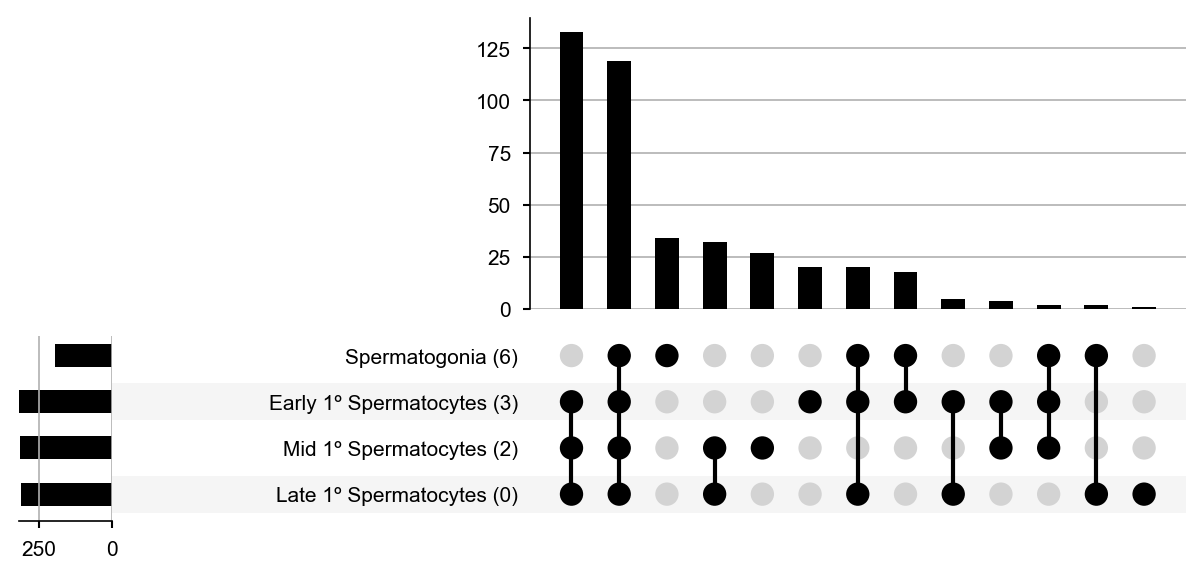

In [590]:
xlink = chroms.query('chrom == "chr2R"').index

dat = tpm.iloc[:, :-2] > 2

dat = dat.reindex(xlink).dropna()

dat = dat[dat.sum(axis=1) > 0]

_dat = dat.groupby(germ_cells[::-1]).size().sort_values(ascending=False)

subplots = upsetplot.plot(_dat, sort_by='cardinality',sort_sets_by=None)

_dat

In [446]:
import gffutils

db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-16/gtf/dmel_r6-16.gtf.db')

# organize genes by chrom position for easy plotting
locs = []
for gene in db.features_of_type('gene'):
    fbgn = gene.id
    chrom = gene.chrom
    pos = np.min([gene.start, gene.end])
    locs.append((fbgn, chrom, pos))
locs = pd.DataFrame(locs, columns=['FBgn', 'chrom', 'pos']).set_index('FBgn')
locs.chrom = pd.Categorical(locs.chrom, categories=nbconfig.chrom_order, ordered=True)

# remove genes not in the dataset and grab x-linked genes
locs = locs.reindex(tpm.index).dropna()
xlink = chroms.query('chrom == "chrX"').index
locs = locs.reindex(xlink).dropna()

# sort and make an arbitrary location point
locs.sort_values(['chrom', 'pos'], inplace=True)
locs['location'] = range(1, locs['pos'].shape[0] + 1)

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [493]:
dat = locs.join(tpm.iloc[:, :-2])

In [494]:
dat['color'] = dat[germ_cells].idxmax(axis=1)
dat['value'] = dat[germ_cells].max(axis=1)

In [496]:
dat.color = pd.Categorical(dat.color, categories=germ_cells, ordered=True)

In [578]:
_dat = dat[['location', 'value', 'color']]

In [574]:
cmapper = dict(zip(germ_cells, sns.color_palette('Reds_r', n_colors=4)))

In [579]:
cmapper = dict(zip(germ_cells, sns.color_palette('Set1')))

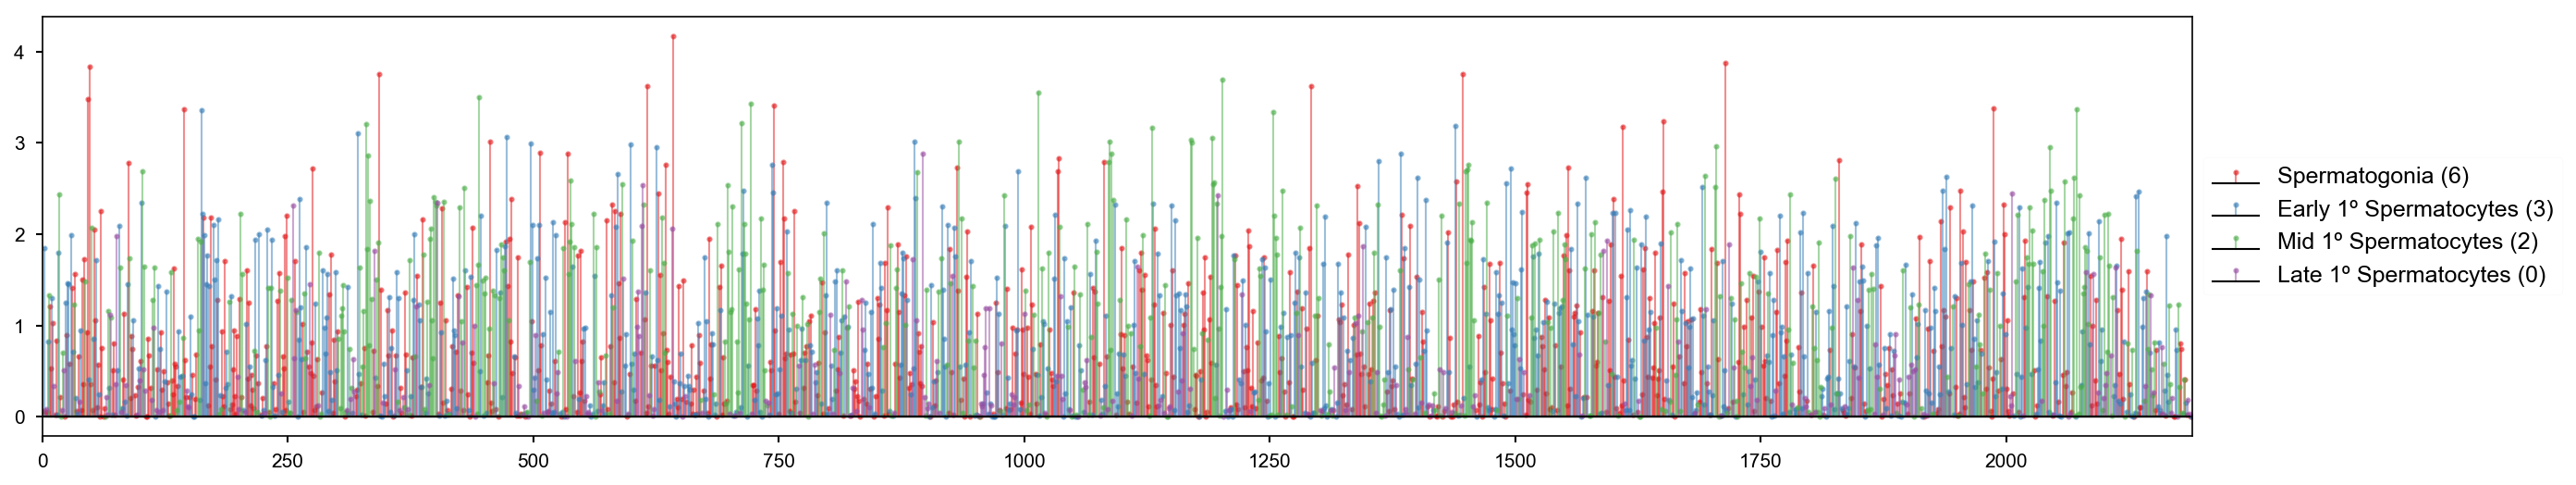

In [581]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
for g, dd in _dat.groupby('color'):
    markerline, stemlines, baseline = ax.stem(dd.location, dd.value, label=g, c=cmapper[g])
    plt.setp(markerline, markerfacecolor=cmapper[g], markeredgecolor=cmapper[g], markersize=2, alpha=.5)
    plt.setp(stemlines, color=cmapper[g], lw=1, alpha=.5)
    plt.setp(baseline, color='k', lw=1)

ax.set_xlim(0, _dat.location.max())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [115]:
expressed = pd.read_parquet('../scrnaseq-wf/data/tpm.parquet').index

In [125]:
df = pd.read_csv('../scrnaseq-wf/data/gonia_vs_early.tsv', sep='\t', index_col=0).query('p_val_adj <= 0.01')
df.index.name = 'FBgn'

In [130]:
up = df.query('avg_logFC > 0').index.tolist()
down = df.query('avg_logFC < 0').index.tolist()

In [180]:
chroms = nbconfig.fbgn2chrom.copy()

In [195]:
chroms.loc[chroms['chrom'] == 'chrX', 'XA'] = 'X'
chroms.loc[chroms['chrom'].isin(['chr2L', 'chr2R', 'chr3L', 'chr3R']), 'XA'] = 'A'
chroms.loc[chroms['chrom'] == 'chr4', 'XA'] = '4'

In [196]:
chroms['sig'] = 'Not Different'

chroms.loc[chroms.index.isin(up), 'sig'] = 'up'
chroms.loc[chroms.index.isin(down), 'sig'] = 'down'

dat = chroms.groupby('XA').sig.value_counts().to_frame()
dat.columns = ['count']
dat = dat.unstack().fillna(0)
dat.columns = dat.columns.droplevel(0)

In [197]:
dat

sig,Not Different,down,up
XA,,,
4,92,5,14
A,12004,1823,935
X,2232,266,171


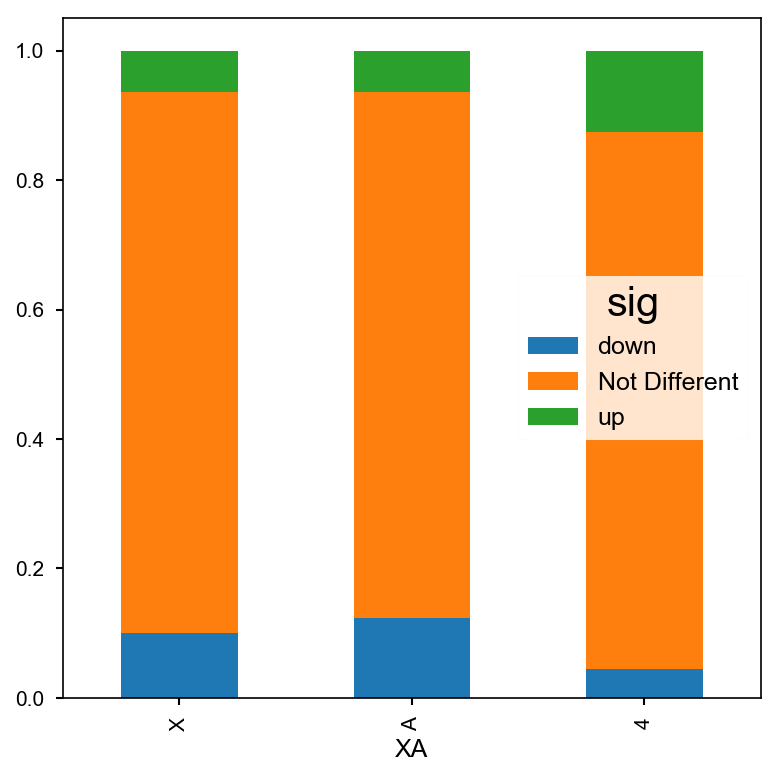

In [199]:
dat.div(dat.sum(axis=1), axis=0).loc[['X', 'A', '4'], ['down', 'Not Different', 'up']].plot.bar(stacked=True)

sig,Not Different,down,up
chrom,,,
chr2L,2821.0,468.0,207.0
chr2R,2922.0,433.0,265.0
chr3L,2834.0,416.0,206.0
chr3R,3427.0,506.0,257.0
chr4,92.0,5.0,14.0
chrM,32.0,6.0,0.0
chrX,2232.0,266.0,171.0
chrY,108.0,5.0,0.0
